In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Esse notebook tem o objetivo de implementar o TSMOM do  Moskowitz. Portanto utilizarei uma parte do dataset, para facilitar a implementação. No dataset estão presentes apenas os preços de fechamento, e apenas de 1999 a 2019.

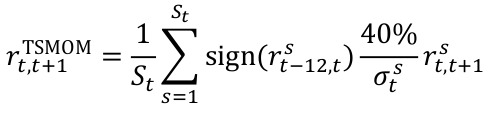

Em resumo a equação final do TSMOM do Moskowitz tem 3 partes: O cálculo do momento do ativo, A poderação do peso no portifolio, e o rendimento do mês aplicado

Cálculo do Momento: Calcula-se o retorno do periodo desejado (no caso da imagem os ultimos 12 meses), e com o retorno e mãos retira-se o sinal, tomando assim uma posição de vendido ou comprado.

O peso no portifolio: Risco buscado no investimento (no caso da imagem 20%), dividido pelo desvio padrão exponencial.



In [2]:
# Importing the cleaned dataset
df = pd.read_csv ("close_clean_data.csv")
df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.drop('date', axis=1)

In [3]:
df.tail()

,AN,BN,CC,CN,CT,DA,DX,EC,EN,ES,...,ZU,ZW,ZZ,DT,HS,LX,NK,SP,UB,AX
date,,,,,,,,,,,,,,,,,,,,,
2019-06-17,68.69,125.91,2479.0,74.680,66.42,16.84,97.050,97.900,7561.25,2896.25,...,52.17,539.50,83.050,171.58,26975.0,7292.5,21095.0,2896.3,134.11,12082.0
2019-06-18,68.92,126.11,2500.0,74.865,66.82,16.86,97.155,97.900,7673.50,2926.25,...,54.11,531.50,81.475,172.76,27269.0,7386.0,21210.0,2926.2,134.61,12321.5
2019-06-19,69.08,127.19,2513.0,75.375,67.16,16.98,96.580,97.995,7702.00,2933.50,...,53.97,522.25,81.625,172.53,27968.0,7331.5,21310.0,2933.4,134.45,12298.0
2019-06-20,69.40,127.48,2446.0,75.925,65.96,17.18,96.140,98.045,7772.75,2960.00,...,57.07,526.50,79.250,172.59,28338.0,7363.5,21460.0,2960.0,134.43,12361.5
2019-06-21,69.44,127.85,2502.0,75.830,65.56,17.09,95.720,98.015,7751.50,2950.50,...,57.43,526.00,76.250,172.08,28255.0,7318.0,21190.0,2950.6,134.26,12270.0


In [4]:
# daily data
returns_daily = df.pct_change().dropna()
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

#monthly data
returns_monthly = df.pct_change(20).dropna().resample('BM').last().ffill()
vol_monthly = (np.sqrt(21)*vol_daily).resample('BM').last().ffill()

In [5]:
vol_monthly.head()

,AN,BN,CC,CN,CT,DA,DX,EC,EN,ES,...,ZU,ZW,ZZ,DT,HS,LX,NK,SP,UB,AX
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,0.029796,0.017777,0.096555,0.022576,0.059210,0.033303,0.016296,0.001930,0.077690,0.048554,...,0.106790,0.041332,0.108112,0.020876,0.061818,0.023549,0.027771,0.048538,0.009124,0.035744
1999-07-30,0.029070,0.026180,0.104204,0.015049,0.070403,0.064684,0.020482,0.001255,0.077308,0.043030,...,0.085605,0.080208,0.117399,0.020742,0.088307,0.063580,0.053543,0.042968,0.011782,0.062118
1999-08-31,0.028643,0.024683,0.090099,0.018660,0.066107,0.074398,0.023288,0.001472,0.080326,0.049175,...,0.082440,0.072389,0.108741,0.020348,0.089065,0.062705,0.054345,0.049120,0.011548,0.063036
1999-09-30,0.028079,0.023481,0.099705,0.017370,0.064985,0.076853,0.022730,0.001673,0.083594,0.052774,...,0.076846,0.073902,0.100052,0.021316,0.083197,0.059348,0.052324,0.052810,0.012297,0.061350
1999-10-29,0.028874,0.023538,0.093439,0.015834,0.061891,0.084342,0.024659,0.001938,0.087608,0.061593,...,0.107029,0.070099,0.099755,0.021418,0.093376,0.060326,0.053840,0.061573,0.012272,0.060487


## Algoritimo

In [6]:
def momentum (returns, passive):
    
    signal = []
    for i in returns:
        if i > 0:
            signal.append(1)
        else:
            if passive:
                signal.append(1)
            else:
                signal.append(-1)
                
    return signal
    
def tsmom (df,returns_monthly, vol_monthly,date, risk=0.4, passive=False, momentum_window=12):
    
    returns_window = df.pct_change(20 * momentum_window).resample('BM').last().ffill()  # momentum 12
    
    position = momentum(returns_window.iloc[date-1], passive)
        
    weights = (risk / vol_monthly.iloc[date-1])
    
    weights /= len(weights)
    
    portfolio = position * weights
    
    return (1+np.dot(portfolio, returns_monthly.iloc[date]))

In [14]:
r = [] # retorno do TSMOM
rp = [] # retorno passivo
start = 12-1
years = 19
end = 12*(int(start/12) + years)
for i in range(start, end):
    r.append(tsmom (df,returns_monthly, vol_monthly, date=i, risk=0.4, momentum_window=12))
    rp.append(tsmom (df,returns_monthly, vol_monthly, date=i, risk=0.4, passive=True))

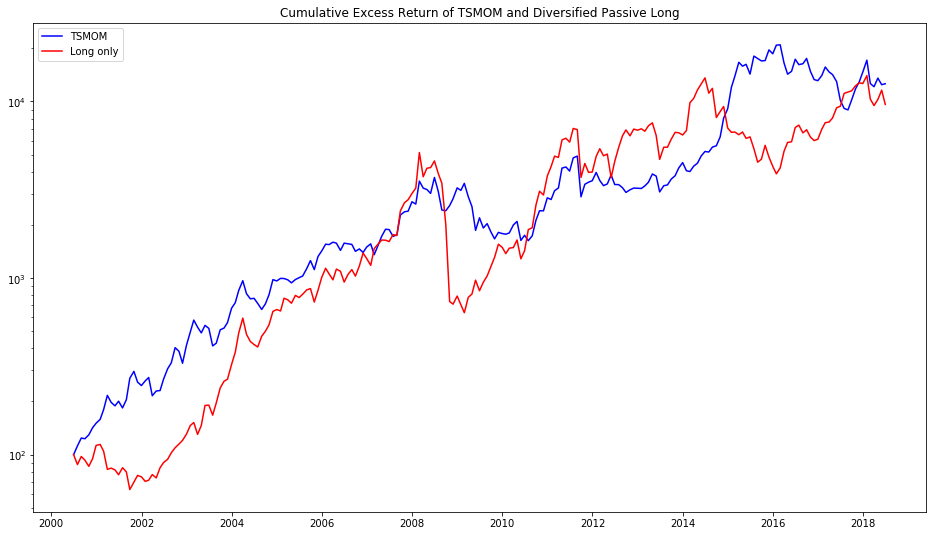

Passive return: 9518.25%, Annualized: 27.17%
TSMOM return: 12497.12%, Annualized: 28.99%


In [17]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

r = pd.DataFrame(r)
rp = pd.DataFrame(rp)

r.index = returns_monthly.iloc[start:end].index
rp.index = returns_monthly.iloc[start:end].index

plt.figure(figsize=(16,9))

plt.plot(100*r.cumprod(), label = 'TSMOM', color='blue')
plt.plot(100*rp.cumprod(), label = 'Long only', color='red')

plt.yscale('log')
plt.legend()
plt.title('Cumulative Excess Return of TSMOM and Diversified Passive Long')
plt.show()

passive_return = float((rp.cumprod().iloc[-1] - 1)*100)
tsmom_return = float((r.cumprod().iloc[-1] - 1)*100)

print('Passive return: ', round(passive_return,2), '%,',
     " Annualized: ", round((((100+passive_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')

print('TSMOM return: ', round(tsmom_return,2), "%,",
     " Annualized: ", round((((100+tsmom_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')